In [35]:
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from keras_tuner import RandomSearch

In [8]:
df = pd.read_csv('training.csv', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'], encoding='ISO-8859-1')
df = df.drop(columns=['query', 'id', 'user', 'date'])

C:\Users\Radosz\AppData\Local\Temp\ipykernel_16396\1493389583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


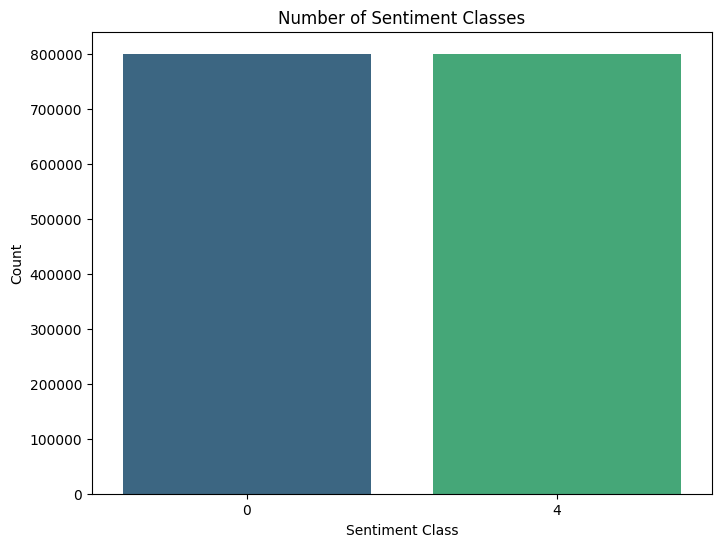

In [9]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Number of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [10]:
def count_hashtags(text):
    return len(re.findall(r'#', text))

def clean_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags and following text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['hashtag_count'] = df['text'].apply(count_hashtags)

In [11]:
df[['text']] = df['text'].apply(lambda x: pd.Series(clean_text(x)))
df

,sentiment,text,hashtag_count
0,0,awww thats a bummer you shoulda got david carr...,0
1,0,is upset that he cant update his facebook by t...,0
2,0,i dived many times for the ball managed to sav...,0
3,0,my whole body feels itchy and like its on fire,0
4,0,no its not behaving at all im mad why am i her...,0
...,...,...,...
1599995,4,just woke up having no school is the best feel...,0
1599996,4,thewdbcom very cool to hear old walt interviews â,0
1599997,4,are you ready for your mojo makeover ask me fo...,0
1599998,4,happy 38th birthday to my boo of alll time tup...,0


In [12]:
num_words=10000
max_length = 20

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_binary = [1 if label == 4 else 0 for label in df['sentiment']]

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)

embedding_dim = 128

# Budowa modelu LSTM
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32
)

results = model.evaluate(X_val, y_val)
print("Loss, Accuracy:", results)

model.save("models/lstm_sentiment_binary_model.h5")

40000/40000 ━━━━━━━━━━━━━━━━━━━━ 223s 6ms/step - accuracy: 0.7843 - loss: 0.4568 - val_accuracy: 0.8153 - val_loss: 0.4043
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8154 - loss: 0.4034


Loss, Accuracy: [0.4043040871620178, 0.815262496471405]


In [16]:
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

In [18]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=hp.Choice('embedding_dim', [64, 128, 256])),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_lstm',
    project_name='lstm_tuning'
)
# Dane wejściowe do Random Search
tuner.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])
)

# Najlepsze hiperparametry
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek LSTM: {best_hps.get('lstm_units')}")
print(f"Współczynnik dropout: {best_hps.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps.get('dense_units')}")
# print(f"Learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 01m 52s]
val_accuracy: 0.6448437571525574

Best val_accuracy So Far: 0.6648468971252441
Total elapsed time: 00h 24m 34s
Najlepsze hiperparametry:
Liczba jednostek LSTM: 32
Współczynnik dropout: 0.2
Liczba jednostek Dense: 80


KeyError: 'learning_rate does not exist.'

In [15]:
# Budowa modelu CNN
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5), 
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32
)

# Ewaluacja modelu
results = model.evaluate(X_val, y_val)
print("Loss, Accuracy:", results)

# Zapis modelu
model.save("models/cnn_sentiment_binary_model.h5")


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - accuracy: 0.7769 - loss: 0.4672 - val_accuracy: 0.8076 - val_loss: 0.4237
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 7s 747us/step - accuracy: 0.8073 - loss: 0.4232


Loss, Accuracy: [0.42367520928382874, 0.8075718879699707]


In [33]:
# Funkcja budowy modelu CNN
def build_cnn_model(hp):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=hp.Choice('embedding_dim', [64, 128, 256])),
        Conv1D(
            filters=hp.Int('filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
            activation='relu'
        ),
        GlobalMaxPooling1D(),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Random Search
tuner_cnn = RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning'
)

# Dane wejściowe do Random Search
tuner_cnn.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])
)

# Najlepsze hiperparametry
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

print(f"Najlepsze hiperparametry:")
print(f"Liczba filtrów: {best_hps_cnn.get('filters')}")
print(f"Rozmiar kernela: {best_hps_cnn.get('kernel_size')}")
print(f"Współczynnik dropout: {best_hps_cnn.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_cnn.get('dense_units')}")
#print(f"Batch size: {best_hps_cnn.get('batch_size')}")
#print(f"Learning rate: {best_hps.get('learning_rate')}")




Reloading Tuner from random_search_cnn\cnn_tuning\tuner0.json
Najlepsze hiperparametry:
Liczba filtrów: 192
Rozmiar kernela: 3
Współczynnik dropout: 0.4
Liczba jednostek Dense: 112


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Budowa modelu GRU
model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),  # Warstwa osadzeń
    GRU(128, return_sequences=False),  # Warstwa GRU, 128 jednostek
    Dropout(0.5),  # Regularizacja
    Dense(32, activation='relu'),  # Warstwa ukryta
    Dense(1, activation='sigmoid')  # Warstwa wyjściowa
])

# Kompilacja modelu
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,  # Liczba epok
    batch_size=32  # Rozmiar wsadu
)

# Ewaluacja modelu
results_gru = model_gru.evaluate(X_val, y_val)
print("Loss, Accuracy:", results_gru)

# Zapis modelu
model_gru.save("models/gru_sentiment_binary_model.h5")


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 296s 7ms/step - accuracy: 0.7815 - loss: 0.4550 - val_accuracy: 0.8159 - val_loss: 0.4048
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8157 - loss: 0.4043


Loss, Accuracy: [0.4048399031162262, 0.8159468770027161]


In [36]:
def build_gru_model(hp):
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])  # Testowane wymiary osadzeń
        ),
        GRU(
            units=hp.Int('gru_units', min_value=64, max_value=256, step=64),  # Liczba jednostek GRU
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),  # Współczynnik Dropout
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')  # Warstwa wyjściowa
    ])
    model.compile(
        optimizer='adam',  # Testowane learning rates
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Random Search
tuner_gru = RandomSearch(
    build_gru_model,
    objective='val_accuracy',  # Cel optymalizacji
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,  # Liczba wykonania na próbę
    directory='random_search_gru',
    project_name='gru_tuning'
)

# Przeprowadzenie wyszukiwania
tuner_gru.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])  # Testowane rozmiary wsadów
)

# Pobranie najlepszych hiperparametrów
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"Najlepsze hiperparametry:")
print(f"Wymiary osadzeń: {best_hps_gru.get('embedding_dim')}")
print(f"Liczba jednostek GRU: {best_hps_gru.get('gru_units')}")
print(f"Współczynnik dropout: {best_hps_gru.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_gru.get('dense_units')}")
# print(f"Learning rate: {best_hps_gru.get('learning_rate')}")
# print(f"Batch size: {best_hps_gru.get('batch_size')}")



Trial 10 Complete [00h 02m 09s]
val_accuracy: 0.6549875140190125

Best val_accuracy So Far: 0.6549875140190125
Total elapsed time: 00h 31m 40s
Najlepsze hiperparametry:
Wymiary osadzeń: 256
Liczba jednostek GRU: 64
Współczynnik dropout: 0.2
Liczba jednostek Dense: 64


In [38]:
# Trenowanie najlepszego modelu GRU
best_model_gru = tuner_gru.hypermodel.build(best_hps)
history_gru = best_model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps.get('batch_size')  # Najlepszy batch size
)

# Ewaluacja
results_gru = best_model_gru.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results_gru)

# Zapis najlepszego modelu
best_model_gru.save("models/best_gru_sentiment_model.h5")

Epoch 1/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 377s 9ms/step - accuracy: 0.7827 - loss: 0.4511 - val_accuracy: 0.8168 - val_loss: 0.4020
Epoch 2/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 356s 9ms/step - accuracy: 0.8233 - loss: 0.3898 - val_accuracy: 0.8191 - val_loss: 0.3970
Epoch 3/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 366s 9ms/step - accuracy: 0.8313 - loss: 0.3763 - val_accuracy: 0.8200 - val_loss: 0.3970
Epoch 4/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 350s 9ms/step - accuracy: 0.8376 - loss: 0.3662 - val_accuracy: 0.8193 - val_loss: 0.3999
Epoch 5/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 358s 9ms/step - accuracy: 0.8405 - loss: 0.3595 - val_accuracy: 0.8187 - val_loss: 0.4047
Epoch 6/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 361s 9ms/step - accuracy: 0.8421 - loss: 0.3566 - val_accuracy: 0.8169 - val_loss: 0.4036
Epoch 7/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 361s 9ms/step - accuracy: 0.8433 - loss: 0.3543 - val_accuracy: 0.8170 - val_loss: 0.4045
Epoch 8/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 362s 9ms/step - ac

Final Loss, Accuracy: [0.40678974986076355, 0.8153093457221985]


In [39]:
# Trenowanie najlepszego modelu CNN
best_model_cnn = tuner_cnn.hypermodel.build(best_hps)
history_cnn = best_model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps.get('batch_size')
)

# Ewaluacja
results_cnn = best_model_cnn.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results_cnn)

# Zapis modelu
best_model_cnn.save("models/best_cnn_sentiment_model.h5")

Epoch 1/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 348s 9ms/step - accuracy: 0.7813 - loss: 0.4595 - val_accuracy: 0.8099 - val_loss: 0.4122
Epoch 2/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 345s 9ms/step - accuracy: 0.8143 - loss: 0.4055 - val_accuracy: 0.8142 - val_loss: 0.4089
Epoch 3/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 346s 9ms/step - accuracy: 0.8243 - loss: 0.3885 - val_accuracy: 0.8151 - val_loss: 0.4037
Epoch 4/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 334s 8ms/step - accuracy: 0.8296 - loss: 0.3779 - val_accuracy: 0.8152 - val_loss: 0.4042
Epoch 5/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 335s 8ms/step - accuracy: 0.8357 - loss: 0.3676 - val_accuracy: 0.8139 - val_loss: 0.4065
Epoch 6/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 2817s 70ms/step - accuracy: 0.8407 - loss: 0.3585 - val_accuracy: 0.8139 - val_loss: 0.4083
Epoch 7/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 363s 9ms/step - accuracy: 0.8454 - loss: 0.3496 - val_accuracy: 0.8128 - val_loss: 0.4096
Epoch 8/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 355s 9ms/step - 

Final Loss, Accuracy: [0.42461884021759033, 0.8093093633651733]


In [ ]:

# Trenowanie najlepszego modelu lstm
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps.get('batch_size')  # Wybór batch_size z hiperparametrów
)

# Ewaluacja
results = best_model.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results)

# Zapis modelu
best_model.save("models/best_lstm_sentiment_model.h5")

Epoch 1/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 403s 10ms/step - accuracy: 0.7812 - loss: 0.4596 - val_accuracy: 0.8098 - val_loss: 0.4142
Epoch 2/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 401s 10ms/step - accuracy: 0.8150 - loss: 0.4056 - val_accuracy: 0.8136 - val_loss: 0.4069
Epoch 3/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 377s 9ms/step - accuracy: 0.8239 - loss: 0.3893 - val_accuracy: 0.8149 - val_loss: 0.4051
Epoch 4/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 407s 10ms/step - accuracy: 0.8304 - loss: 0.3769 - val_accuracy: 0.8151 - val_loss: 0.4053
Epoch 5/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 405s 10ms/step - accuracy: 0.8364 - loss: 0.3666 - val_accuracy: 0.8128 - val_loss: 0.4094
Epoch 6/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 397s 10ms/step - accuracy: 0.8417 - loss: 0.3577 - val_accuracy: 0.8149 - val_loss: 0.4063
Epoch 7/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 400s 10ms/step - accuracy: 0.8450 - loss: 0.3498 - val_accuracy: 0.8146 - val_loss: 0.4103
Epoch 8/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 416s 10ms/st

Final Loss, Accuracy: [0.41957002878189087, 0.8116124868392944]
